In [2]:
%matplotlib inline
import numpy as np
import csv
import os
from glob import glob
import SimpleITK as sitk
import random
from myshow import myshow


from IPython import display
import matplotlib.pyplot as plt

import sklearn

from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.cross_validation import train_test_split

random_seed = 142

/home/mostafa/anaconda3/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [109]:
def get_mean(stat, skip=0, steps=3) :
    
    if(len(stat) < steps):
        return None
    
    x = list(reversed(stat))
    d = np.array(x[skip:skip+steps])
    val = d[:, 1]
    return (sum(val) / steps)
    
    
def get_mean_diff(stat, steps=3) :
    if(len(stat) < steps * 2):
        return None
    
    x_new = get_mean(stat, skip=0, steps=steps)
    x_old = get_mean(stat, skip=steps, steps=steps)
    return x_new - x_old

def fc_b(x, w, b, drop_out, is_out=False):

    # Fully connected layer
    net = tf.reshape(x, [-1, w.get_shape().as_list()[0]])
    net = tf.add(tf.matmul(net, w), b)
    if not is_out:
        net = tf.nn.relu(net)
        net = tf.nn.dropout(net, drop_out)
    return net


def get_batch(data_x, data_y, batch_size):
    x = []
    y = []
    indices = np.random.randint(0, data_x.shape[0], batch_size)
    for i in indices:
        x.append(data_x[i])
        y.append(data_y[i])
    
    return np.array(x), np.array(y)

training_iters = 8000000
display_step = 500
batch_size = 32

def update_graph(loss_data, train_acc, test_acc, learning_rate):
    
        
    display.clear_output(wait=True)
    
    fig, ax_arr = plt.subplots(3, sharex=True)

    d = np.array(loss_data)
    x_data = d[:, 0]
    y_data = d[:, 1]
    ax_arr[0].set_ylabel('Loss')
    ax_arr[0].plot(x_data, y_data, label="loss")
    ax_arr[0].legend(framealpha=0.5, loc="lower left")
    
    d1 = np.array(train_acc)
    d2 = np.array(test_acc)
    x1_data = d1[:, 0]
    y1_data = d1[:, 1]
    x2_data = d2[:, 0]
    y2_data = d2[:, 1]
    ax_arr[1].set_ylabel('Accuracy')
    ax_arr[1].set_xlabel('Iterations')
    ax_arr[1].plot(x1_data, y1_data, 'r-', label="training")
    ax_arr[1].plot(x2_data, y2_data, 'g-', label="testing")
    ax_arr[1].legend(framealpha=0.5, loc="lower left")
    
    d = np.array(learning_rate)
    x_data = d[:, 0]
    y_data = d[:, 1]
    ax_arr[2].set_ylabel('Learning rate')
    ax_arr[2].plot(x_data, y_data, label="learning rate")
    ax_arr[2].legend(framealpha=0.5, loc="lower left")
    
    fig.set_size_inches(18.5, 10.5)
    
    plt.show()



def run_graph(
        X_train, 
        X_test, 
        y_train, 
        y_test,
        layer_params,
        drop_out=0.5,
        reg_power=5e-4,
        learning_rate=1e-5):
    
    stat_train_acc = []
    stat_test_acc = []
    stat_data_loss = []
    stat_learning_rate = []
    
    sm_stat_train_acc = []
    sm_stat_test_acc = []
    sm_stat_data_loss = []
    
    
    tf.reset_default_graph()
    
    num_features = X_train.shape[1]
    num_classes = y_train.shape[1]
    
    # Assume random accurecy is 1/n_class +/- 10%
    rand_acc_range = [
        int(100 * (1/num_classes) - (1/num_classes * 10)), 
        int(100 * (1/num_classes) + (1/num_classes * 10))
    ]
    
    sess = tf.Session()



    # tf Graph input
    x = tf.placeholder(tf.float32, [None, num_features], name="x")
    y = tf.placeholder(tf.float32, [None, num_classes], name="y")

    net = x

    previous_layer_size = num_features
    reg = 0
    for idx, current_layer_size in enumerate(layer_params):
        w_id = "W_" + str(idx)
        w = tf.get_variable(w_id, shape=(previous_layer_size, current_layer_size), initializer=tf.contrib.layers.xavier_initializer())
        b = tf.Variable(tf.random_normal([current_layer_size]))
        net = fc_b(net, w, b, drop_out)
        previous_layer_size = current_layer_size
        reg += tf.nn.l2_loss(w) + tf.nn.l2_loss(b)

    w_id = "W_" + str(len(layer_params))
    w = tf.get_variable(w_id, shape=(previous_layer_size, num_classes), initializer=tf.contrib.layers.xavier_initializer())
    b = tf.Variable(tf.random_normal([num_classes]))
    pred = fc_b(net, w, b, 1, is_out=True)
    
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(pred, y))
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
    
    cost += reg_power * reg
    
    # Evaluate model
    correct_pred = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))
    with tf.name_scope('accuracy'):
        accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))
        tf.scalar_summary('accuracy', accuracy)

    # Initializing the variables
    merged = tf.merge_all_summaries()

    init = tf.initialize_all_variables()
    sess.run(init)
  
    stat_step = 20
    display_step = 2000
    train_loss = 0
    step = 1
    try:
        with sess:


            # Keyep training until reach max iterations
            while step * batch_size < training_iters:

                batch_x, batch_y = get_batch(X_train, y_train, batch_size)
                train_dict = {
                    x: batch_x,
                    y: batch_y
                }

                # Run optimization op (backprop)
                summary, _ = sess.run([merged, optimizer], feed_dict=train_dict)
                
                if step % stat_step == 0:
                    
                    test_batch_x, test_batch_y = get_batch(X_test, y_test, 32)
                    test_dict = {
                        x: test_batch_x,
                        y: test_batch_y
                    }
                        
                    train_acc, train_loss = sess.run([accuracy, cost], feed_dict=train_dict)
                    summary, test_acc = sess.run([merged, accuracy], feed_dict=test_dict)
                    stat_data_loss.append([step * batch_size, train_loss])
                    stat_train_acc.append([step * batch_size, train_acc])
                    stat_test_acc.append([step * batch_size, test_acc])
                    stat_learning_rate.append([step * batch_size, learning_rate])
                    
                
                if step % display_step == 0:
                    
                    steps_count = int(display_step / stat_step)
                    tr_acc = int(get_mean(stat_train_acc, steps=steps_count) * 100)
                    ts_acc = int(get_mean(stat_test_acc, steps=steps_count) * 100)
                    sm_stat_train_acc.append([step * batch_size, tr_acc])
                    sm_stat_test_acc.append([step * batch_size, ts_acc])
                    
                    progress = get_mean_diff(stat_train_acc, steps_count)
                    
                    if progress is not None:
                        if tr_acc < rand_acc_range[1]:
                            if progress is not None and progress < 10:
                                #lr_value = 1e-3
                                pass
                        else:
                            if progress is not None and progress < 5:
                                # lr_value = 1e-7
                                pass


                    update_graph(stat_data_loss, sm_stat_train_acc, sm_stat_test_acc, stat_learning_rate)

                    prg = 0 if progress is None else progress
                    print("Iter " + str(step * batch_size) +
                          ", Loss = {:.6f}".format(train_loss) +
                          ", Training Accuracy = {:.3f}".format(tr_acc) +
                          ", Test Accuracy = {:.3f}".format(ts_acc)
                      )

                step += 1

            print("Optimization Finished!")
    except KeyboardInterrupt:
            print("Optimization Terminated!")

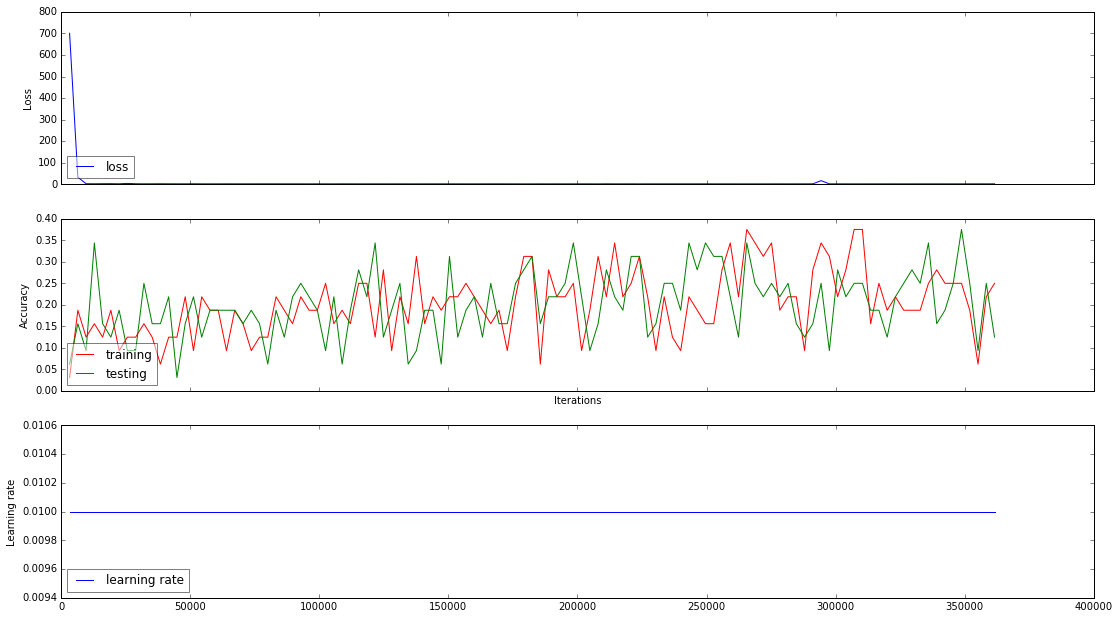

Iter 361600, Minibatch Loss = 1.757754, Training Accuracy = 0.25000, Test Accuracy = 0.12500
Optimization Terminated!


In [28]:
X = np.load('/home/mostafa/spiromics/AMFM/SafeOutput/X_raw.npy')
Y = np.load('/home/mostafa/spiromics/AMFM/SafeOutput/Y.npy')

    
X.shape = (4464, 15, 15, 23)

X.shape = (4464, -1)


X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.10, random_state=random_seed)
training_iters = 8000000
display_step = 200
batch_size = 32
run_graph(X_train, X_test, y_train, y_test)

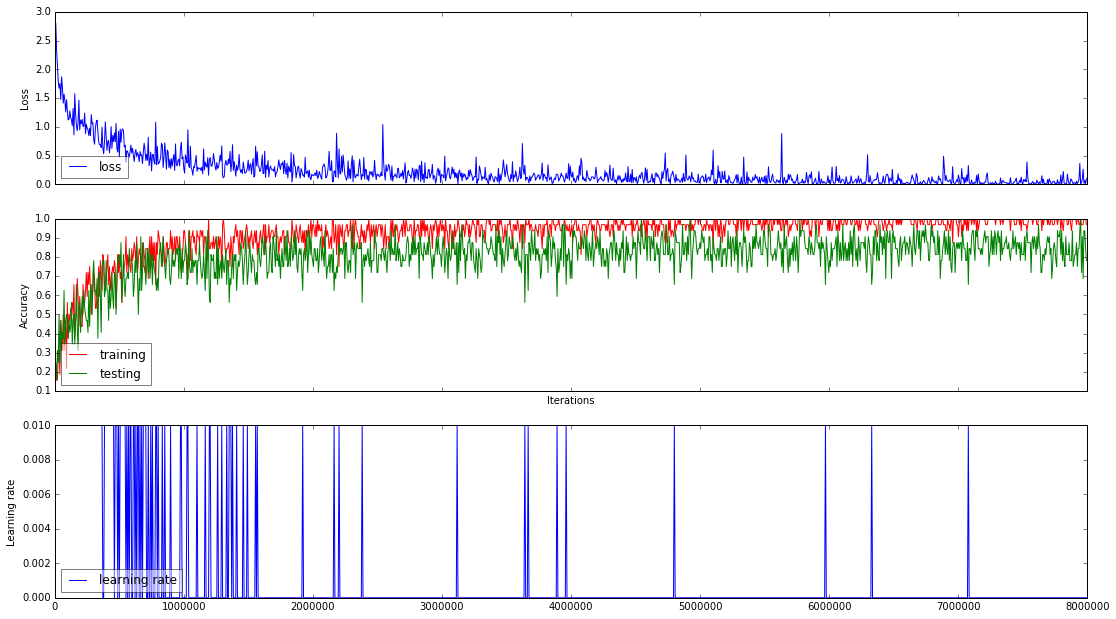

Iter 7993600, Minibatch Loss = 0.096441, Training Accuracy = 0.96875, Test Accuracy = 0.78125
Optimization Finished!


In [35]:
X = np.load('/home/mostafa/spiromics/AMFM/SafeOutput/X_raw.npy')
Y = np.load('/home/mostafa/spiromics/AMFM/SafeOutput/Y.npy')

    
X.shape = (4464, 15, 15, 23)


X.shape = (4464, -1)
X -= np.mean(X, axis=0)
X /= np.std(X)


X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.10, random_state=random_seed)
training_iters = 8000000
display_step = 200
batch_size = 32
learning_rate = 1e-4
run_graph(X_train, X_test, y_train, y_test, learning_rate)

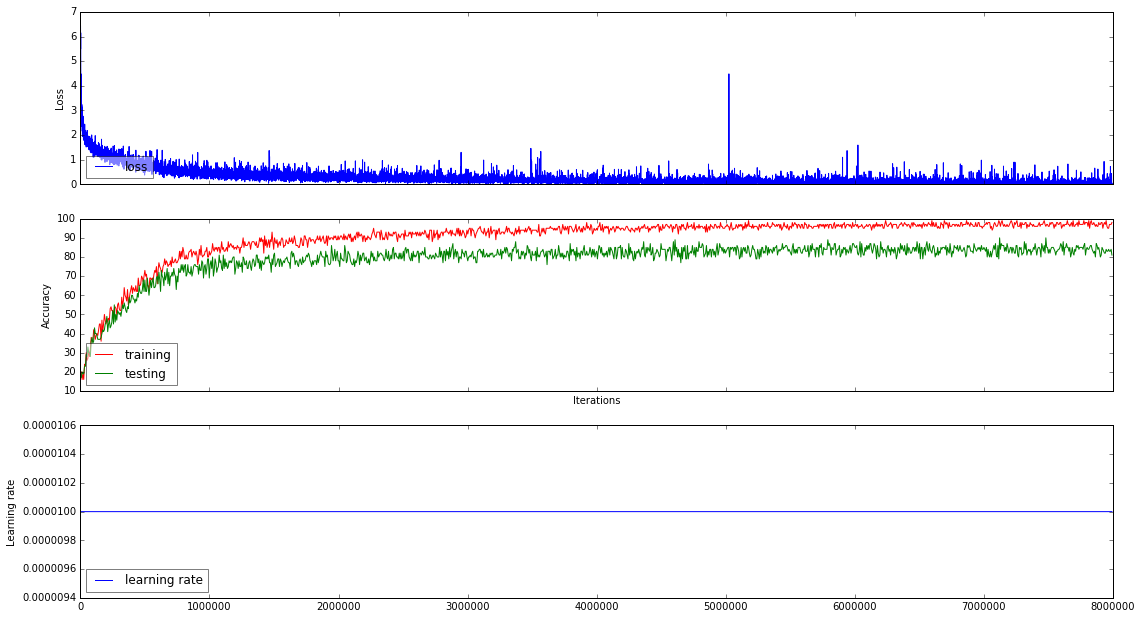

Iter 7993600, Diff = 0, LR = 0.000010, Training Accuracy = 98.000, Test Accuracy = 81.000
Optimization Finished!


In [110]:
X = np.load('/home/mostafa/spiromics/AMFM/SafeOutput/X_raw.npy')
Y = np.load('/home/mostafa/spiromics/AMFM/SafeOutput/Y.npy')

    
X.shape = (4464, 15, 15, 23)


X.shape = (4464, -1)
X -= np.mean(X, axis=0)
X /= np.std(X)


X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.05, random_state=random_seed)
training_iters = 8000000
display_step = 200
batch_size = 32
learning_rate = 1e-5
run_graph(X_train, X_test, y_train, y_test, learning_rate)

In [16]:
X_train = np.load('./Data/X_train_raw.npy')
Y_train = np.load('./Data/Y_train_raw.npy')
X_test  = np.load('./Data/X_test_raw.npy')
Y_test  = np.load('./Data/Y_test_raw.npy')

#(4464, 15, 15, 23)

    

X_train.shape = (X_train.shape[0], -1)
X_test.shape = (X_test.shape[0], -1)

pca = PCA(whiten=True)
pca.fit(X_test)
X_test = pca.transform(X_test)
pca = PCA(whiten=True)
pca.fit(X_train)
X_train = pca.transform(X_train)



print(X_test.shape)
print(X_train.shape)

#X_train -= np.mean(X_train, axis=0)
#X_train /= np.std(X_train)

#X_test -= np.mean(X_test, axis=0)
#X_test /= np.std(X_test)


print("Training examples: " + str(len(Y_train)))
print("Ratios: " + str(np.sum(Y_train, axis=0)/np.sum(Y_train)))


print("Test examples: " + str(len(Y_test)))
print("Ratios: " + str(np.sum(Y_test, axis=0)/np.sum(Y_test)))

(192, 192)
(4272, 4272)
Training examples: 4272
Ratios: [ 0.13670412  0.15730337  0.16292135  0.17602996  0.14044944  0.22659176]
Test examples: 192
Ratios: [ 0.125       0.16666667  0.16666667  0.16666667  0.125       0.25      ]
